# Libraries

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import modelConv2d
from src.models import modelineal
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'modelConv2d' from 'src' (unknown location)

# Pendulum

### Load Data

In [3]:
g=9.81
L=1
x0=np.pi/2
x1=np.pi/2.5
t,a = genData.generatePendulumA(g,L,x0, x1)

<Figure size 640x480 with 0 Axes>

In [4]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)

### Visualizations

In [4]:
img = genData.create_pendulum_image(90)
print("Image shape:", img.size)
genData.generateVideo()

Image shape: (500, 260)


<Figure size 640x480 with 0 Axes>

In [5]:
genData.generateVideo()

<Figure size 640x480 with 0 Axes>

In [7]:
###### uncoment to see dataset example  ######

# data_iter = iter(train_dataloader)

# # Get a batch of data
# batch_data = next(data_iter)

# # Get the shape of the batch
# batch_shape = batch_data[0][0].shape

# print("Batch shape:", batch_shape)

# testimage = batch_data[0][0][0]
# cmap = plt.cm.get_cmap('Greys_r', 256)

# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][29]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][30]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][31]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

#cp.plotMatrix(testimage.permute(1, 2, 0),'xlabel', 'ylabel','title', 'name', styleDark = True)

In [69]:
###### uncoment to see dataset example  ######
# im1 = genData.create_pendulum_image(0.1)
# print("Image shape:", im1.size)
# plt.figure()
# plt.imshow(im1)
# from torchvision import transforms
# convert_tensor = transforms.ToTensor()

# tensor_image = convert_tensor(im1)
# # Print tensor image shape
# print("Tensor image shape:", tensor_image.shape)
# # print max value torch tensor
# print("Max value:", torch.max(tensor_image))
# plt.figure()
# plt.imshow(  tensor_image.permute(1, 2, 0)  )

### Visualization 3D dataset

Batch shape: torch.Size([32, 3, 260, 500])
torch.Size([3, 260, 500])
torch.Size([1, 260, 500])


/tmp/ipykernel_4095/685028545.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
/tmp/ipykernel_4095/685028545.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


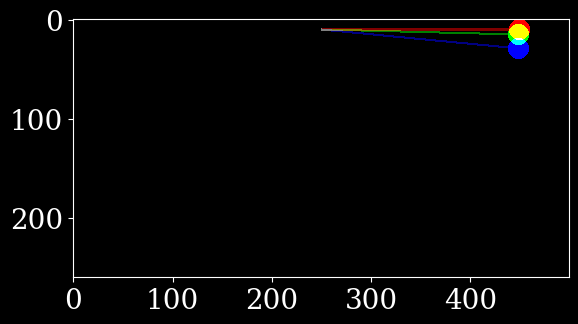

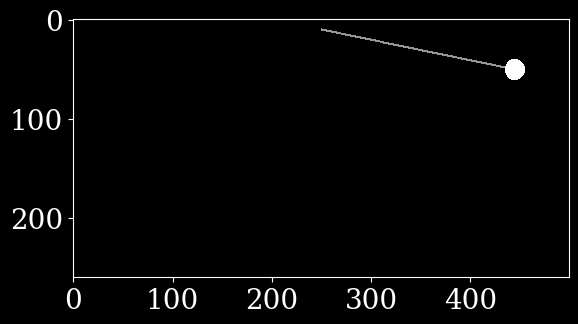

In [10]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')


### Model Conv3D

In [11]:

#train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)
modelAE = models.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

IndexError: list index out of range

#### Visual Test

In [12]:
visual_loader= loader.getLoader(a, split=False)

In [13]:
vu.visualize(modelAE, visual_loader)

NameError: name 'modelAE' is not defined

<Figure size 640x480 with 0 Axes>

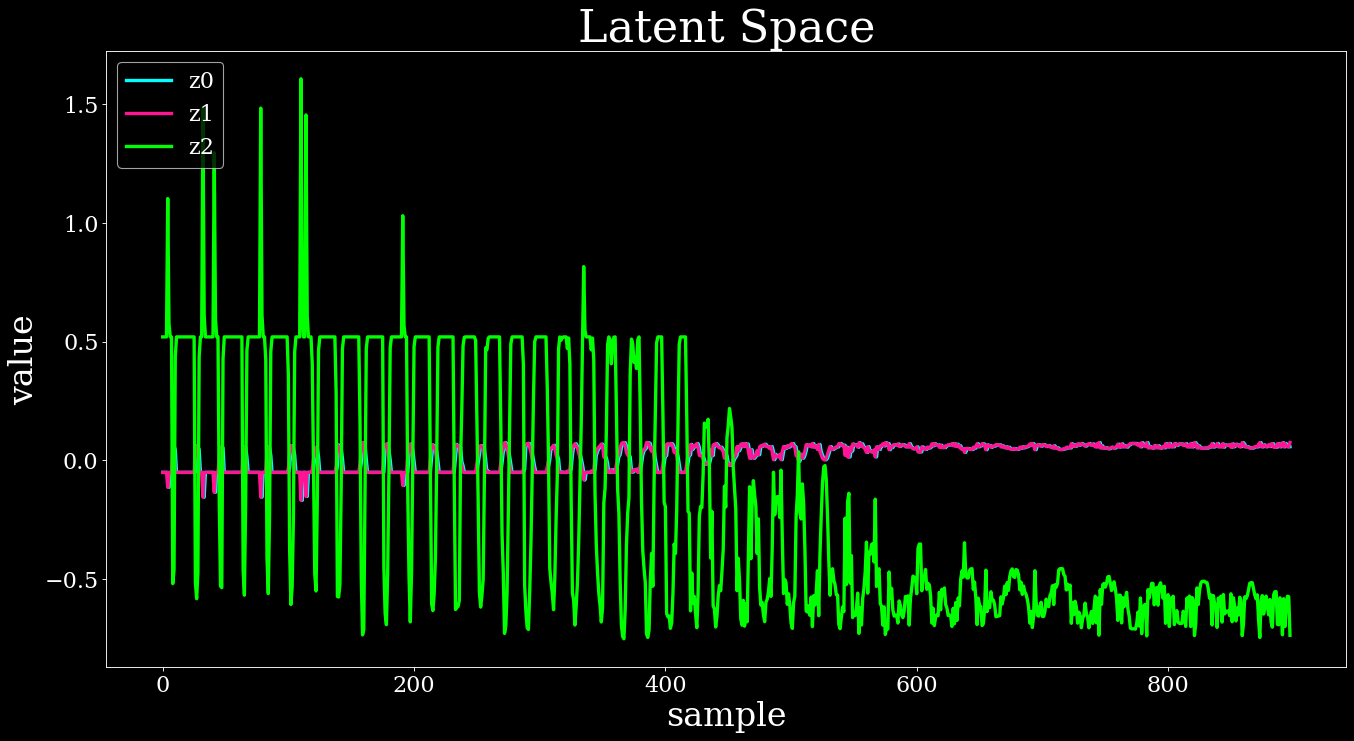

In [44]:
vu.CompareLatent(modelAE, visual_loader)

### Model Conv2d

Using device: cuda
epoch: 2 	 training loss: 0.0077855517561344996 	 validation loss: 0.0077446250555415945
epoch: 4 	 training loss: 0.0077281988468831 	 validation loss: 0.007719971550007661
epoch: 6 	 training loss: 0.007672971094270115 	 validation loss: 0.007598207254583637
epoch: 8 	 training loss: 0.007497677316322275 	 validation loss: 0.007370046727980177
epoch: 10 	 training loss: 0.007421899202239254 	 validation loss: 0.007237184404705961
epoch: 12 	 training loss: 0.007380851584932078 	 validation loss: 0.007119542142997186
epoch: 14 	 training loss: 0.007324234825437484 	 validation loss: 0.007006919709965587
epoch: 16 	 training loss: 0.007293946393158125 	 validation loss: 0.0069684806900719804
epoch: 18 	 training loss: 0.0072872305045957155 	 validation loss: 0.0069409022107720375
epoch: 20 	 training loss: 0.007260584069982819 	 validation loss: 0.006903703790158033


<Figure size 640x480 with 0 Axes>

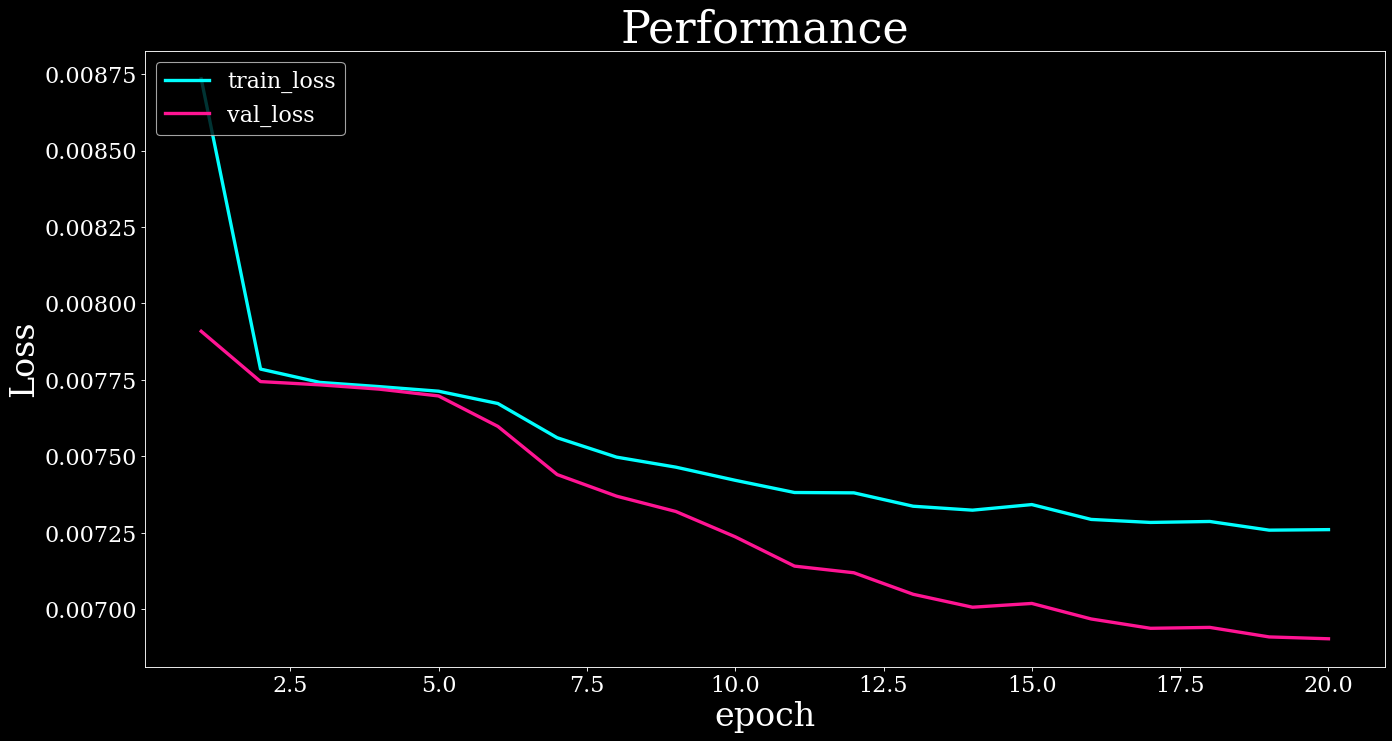

In [6]:
modelAE = modelConv2d.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

In [7]:
visual_loader= loader.getLoader(a, split=False)

In [12]:
vu.visualize(modelAE, visual_loader, video_name = 'Conv2d_ExpVsPred.mp4')

Video saved as Conv2d_ExpVsPred.mp4


<Figure size 640x480 with 0 Axes>

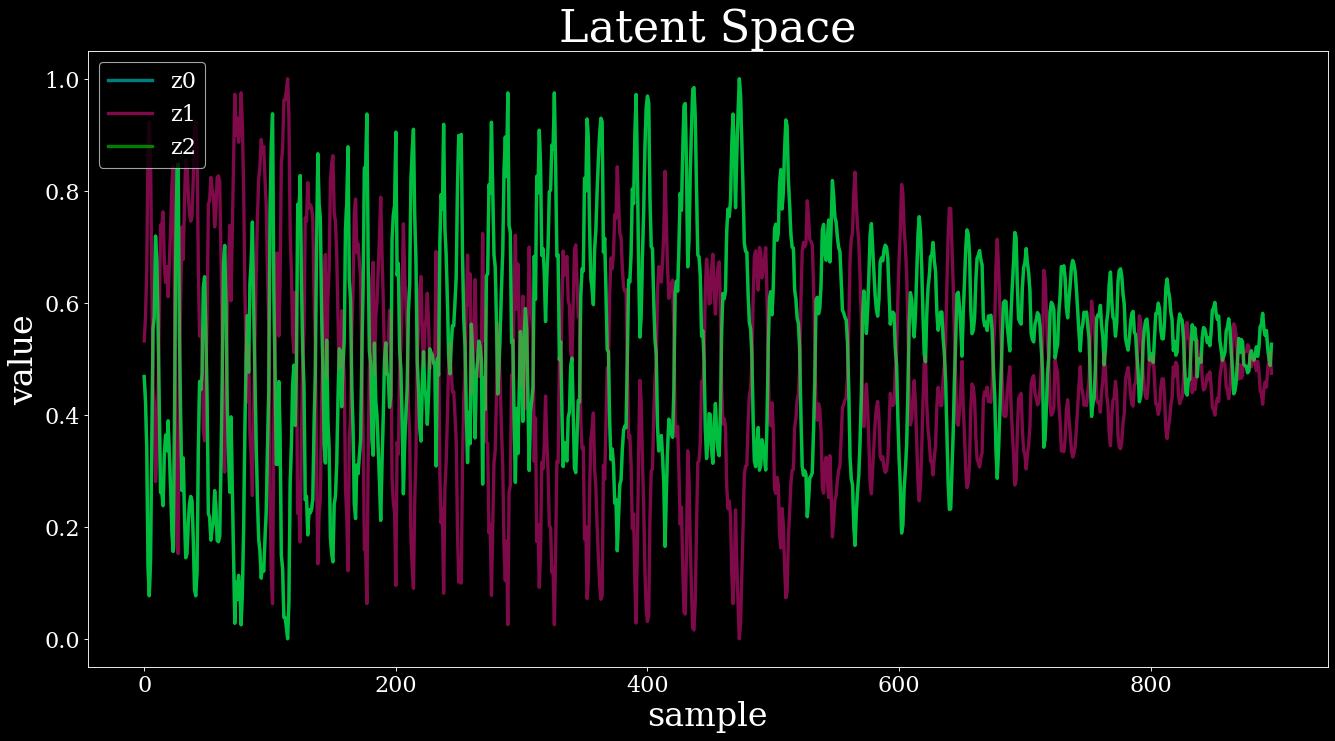

In [11]:
vu.CompareLatent(modelAE, visual_loader)

### Model Lineal

Using device: cuda
epoch: 2 	 training loss: 0.007626414258518945 	 validation loss: 0.007330852948750059
epoch: 4 	 training loss: 0.007281827092494654 	 validation loss: 0.006999196562295158
epoch: 6 	 training loss: 0.007255601271501054 	 validation loss: 0.006856800289824605
epoch: 8 	 training loss: 0.00723997979303417 	 validation loss: 0.006830619104827444
epoch: 10 	 training loss: 0.0072318640051652556 	 validation loss: 0.006821838750814398
epoch: 12 	 training loss: 0.007226657972711584 	 validation loss: 0.006815505136425297
epoch: 14 	 training loss: 0.0072232803289333115 	 validation loss: 0.006811484151209394
epoch: 16 	 training loss: 0.007221025718457025 	 validation loss: 0.006808608304709196
epoch: 18 	 training loss: 0.0072194128904653635 	 validation loss: 0.006806049185494582
epoch: 20 	 training loss: 0.007217927795389424 	 validation loss: 0.006803764263167977


<Figure size 640x480 with 0 Axes>

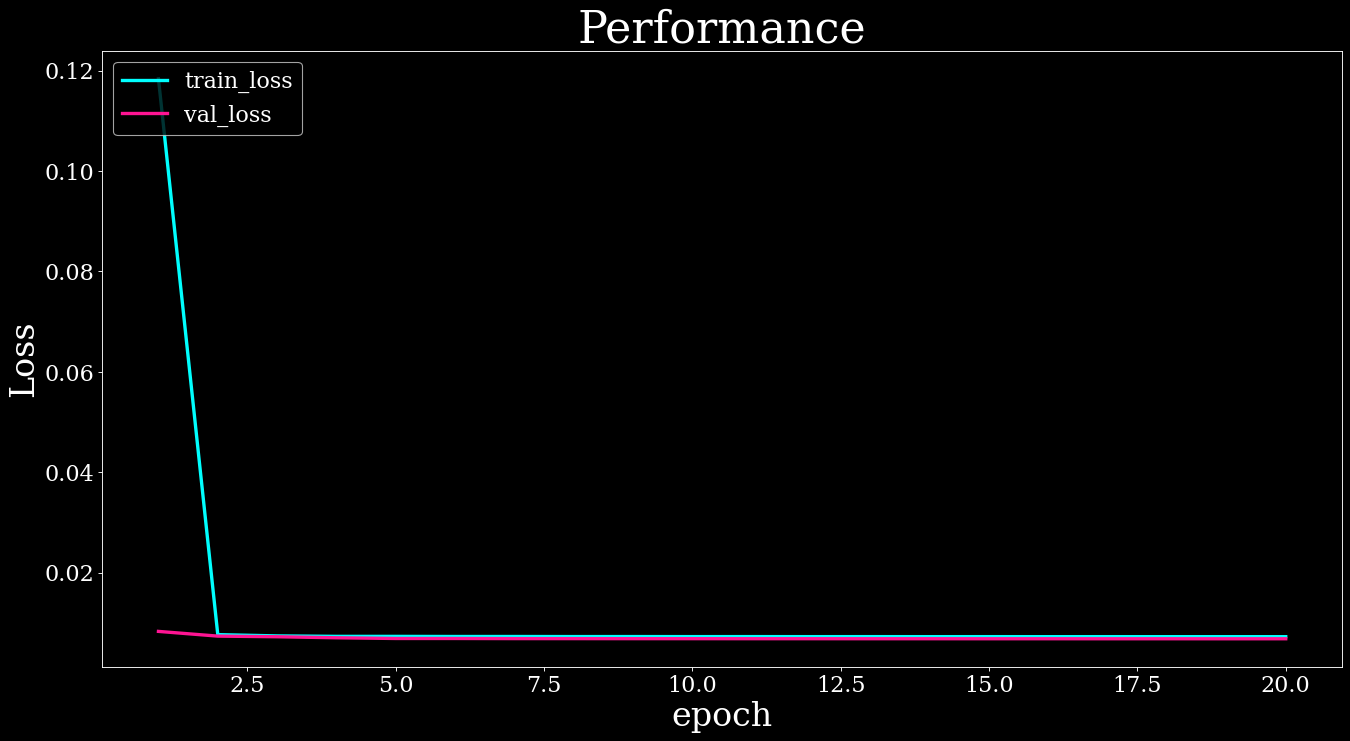

In [21]:
linealmodel = modelineal.AE(dt=1/30, initw=True)
linealmodel, train_losses, val_losses, accuracy_list  = train.train(linealmodel, train_dataloader, test_dataloader, 'LinelModel')

In [22]:
visual_loader= loader.getLoader(a, split=False)

In [23]:
vu.visualize(linealmodel, visual_loader, video_name = 'LinealModel_ExpVsPred.mp4')

Video saved as LinealModel_ExpVsPred.mp4


<Figure size 640x480 with 0 Axes>

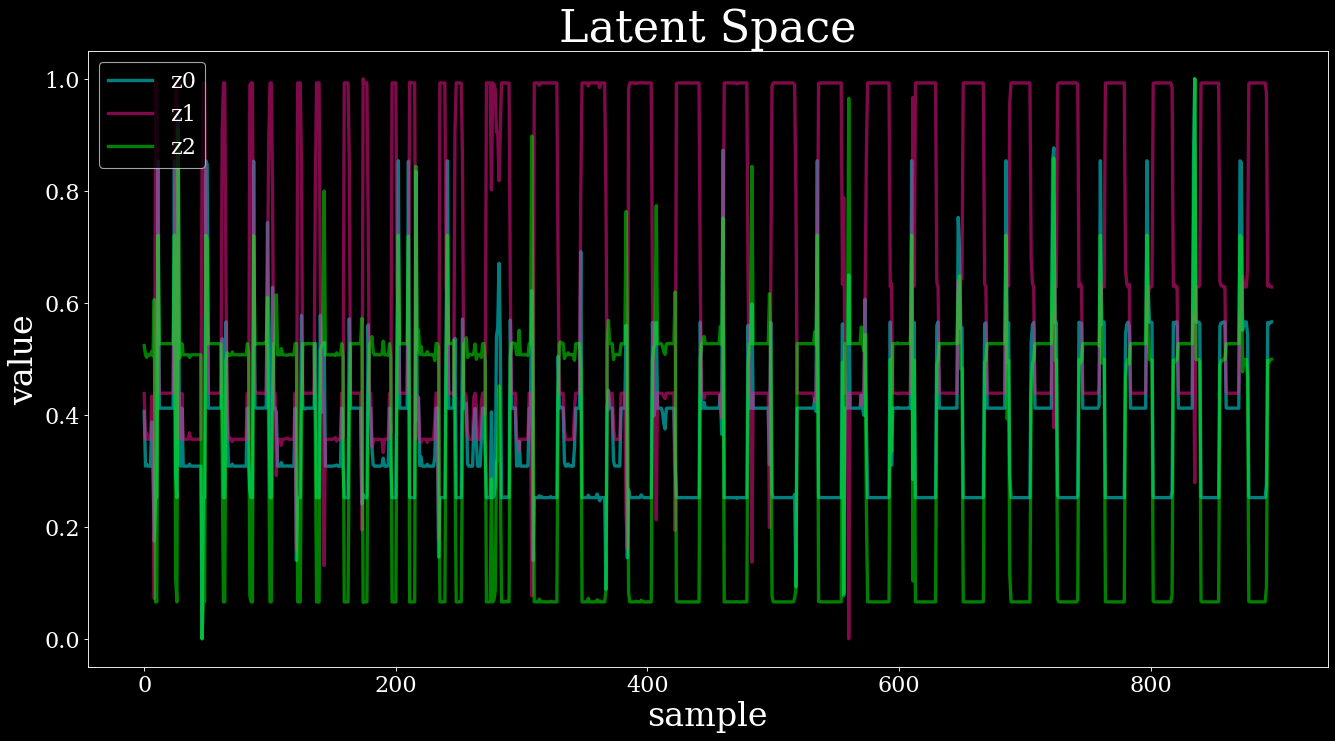

In [24]:
vu.CompareLatent(linealmodel, visual_loader, name='latentSapce_LinealModel.png')

### Test Decoder

In [27]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type = "Dataset_decoder")
visual_loader= loader.getLoader(a, split=False, type = "Dataset_decoder")

#### Linear

In [28]:
linearDecoder = modelineal.Decoder(initw=True)

Using device: cpu
epoch: 2 	 training loss: 0.012668797665316126 	 validation loss: 0.03200358214477698
epoch: 4 	 training loss: 0.00900071353206168 	 validation loss: 0.021262341334174078
epoch: 6 	 training loss: 0.007649606164625805 	 validation loss: 0.016277366628249485
epoch: 8 	 training loss: 0.006776542817849828 	 validation loss: 0.013157925102859735
epoch: 10 	 training loss: 0.006187784029980717 	 validation loss: 0.011080001015216112
epoch: 12 	 training loss: 0.005783648878012014 	 validation loss: 0.009720661832640568
epoch: 14 	 training loss: 0.005460187985116373 	 validation loss: 0.00869740848429501
epoch: 16 	 training loss: 0.0052258714770331335 	 validation loss: 0.007926780342434844
epoch: 18 	 training loss: 0.005056387846074675 	 validation loss: 0.007354445212210218
epoch: 20 	 training loss: 0.004899973717882582 	 validation loss: 0.006867084264134367


FileNotFoundError: [Errno 2] No such file or directory: './plots/.Results/linearDecoder.png'

<Figure size 640x480 with 0 Axes>

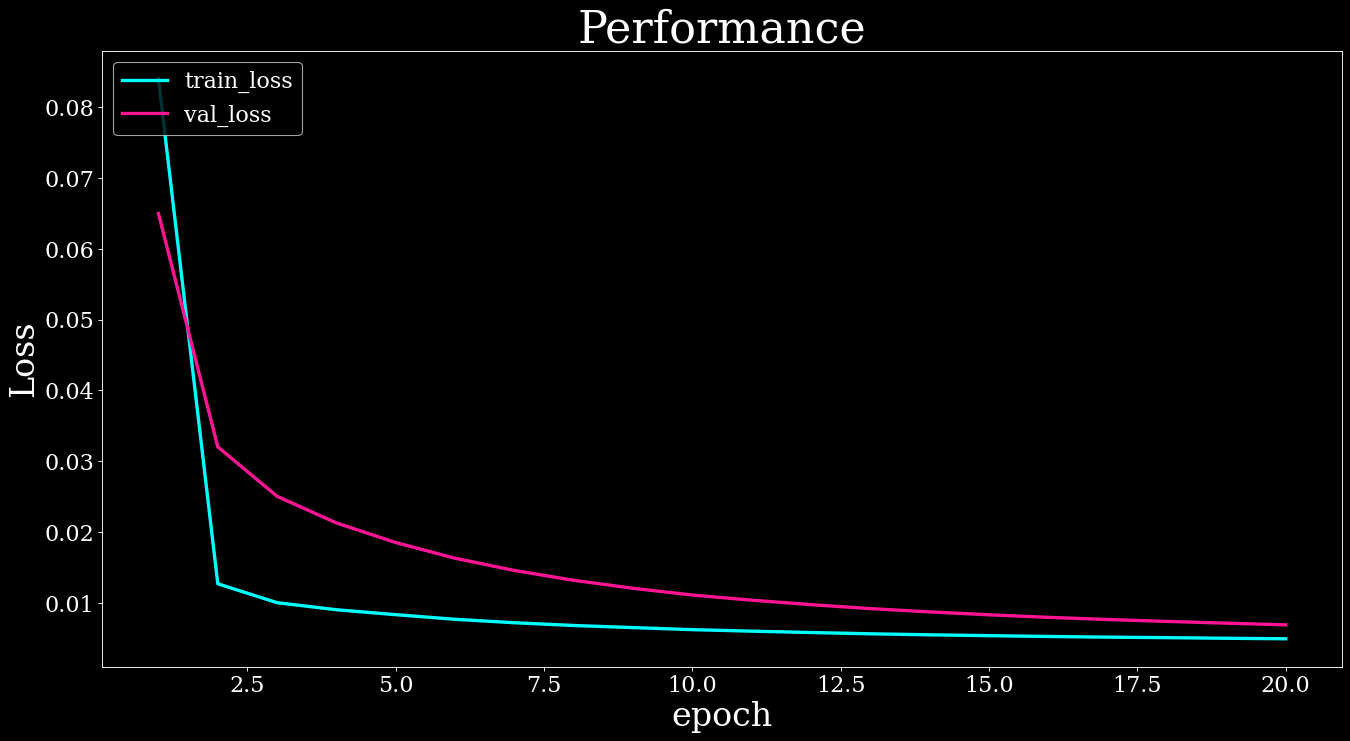

In [29]:

linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/linearDecoder', loss_name='decoder_loss')

In [31]:
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/LinearDecoder_ExpVsPred.mp4')

Video saved as ./Results/LinearDecoder_ExpVsPred.mp4


#### Conv2D

Using device: cpu
epoch: 2 	 training loss: 0.0037581729095267215 	 validation loss: 0.003758303316620489
epoch: 4 	 training loss: 0.003758256515973936 	 validation loss: 0.0037583046359941363
epoch: 6 	 training loss: 0.0037582783008237248 	 validation loss: 0.003758304325553278
epoch: 8 	 training loss: 0.0037582842430666738 	 validation loss: 0.0037583319935947657
epoch: 10 	 training loss: 0.003758277470731865 	 validation loss: 0.0037583501543849707
epoch: 12 	 training loss: 0.00375827072876627 	 validation loss: 0.0037583555870999894
epoch: 14 	 training loss: 0.0037582673982757588 	 validation loss: 0.003758356130371491
epoch: 16 	 training loss: 0.0037582664062147555 	 validation loss: 0.003758356402007242
epoch: 18 	 training loss: 0.00375826595067654 	 validation loss: 0.0037583564408123493
epoch: 20 	 training loss: 0.0037582657279689674 	 validation loss: 0.003758356246786813


<Figure size 640x480 with 0 Axes>

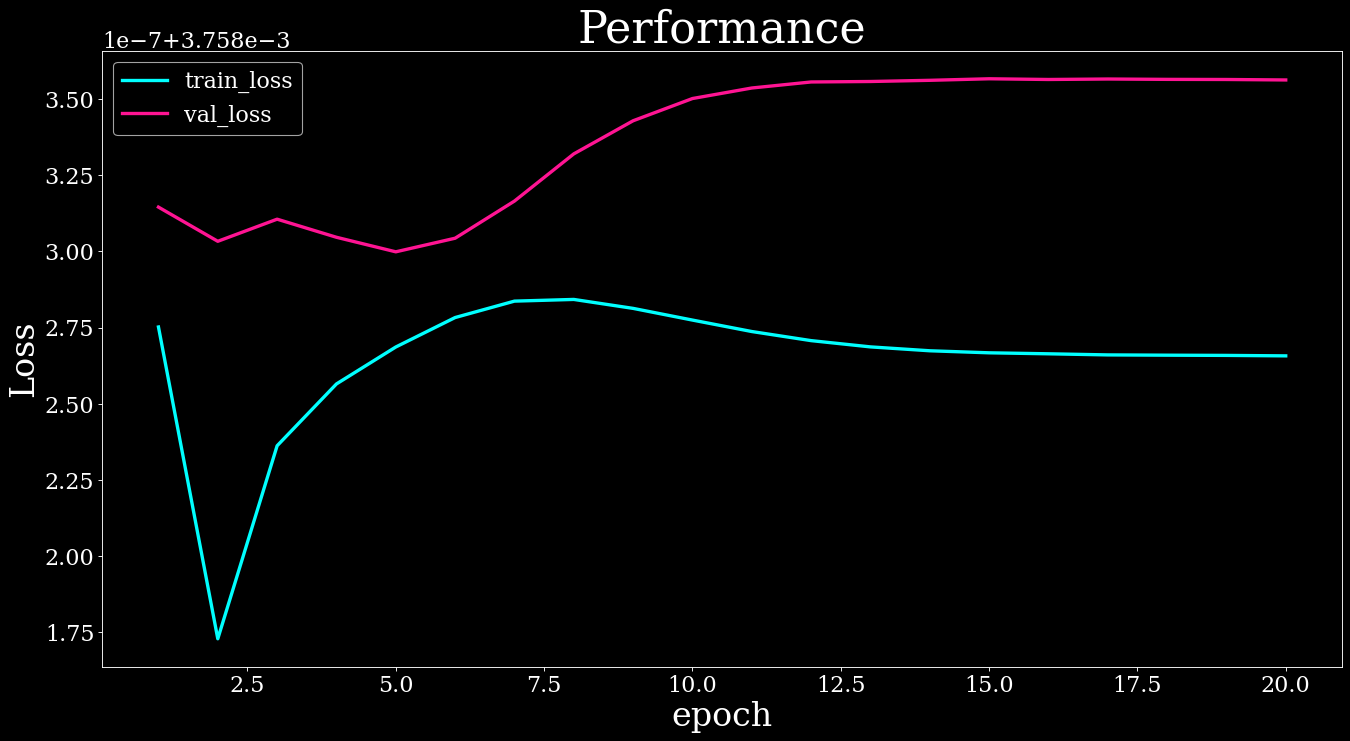

In [12]:
con2dDecoder = modelConv2d.FullDecoder(initw=True)
con2dDecoder, train_losses, val_losses, accuracy_list  = train.train(con2dDecoder, train_dataloader, test_dataloader, 'con2dDecoder', loss_name='Focal_batch_loss')

In [13]:
vu.visualize_dec(con2dDecoder, visual_loader, video_name = 'con2dDecoder.mp4')

Video saved as con2dDecoder.mp4


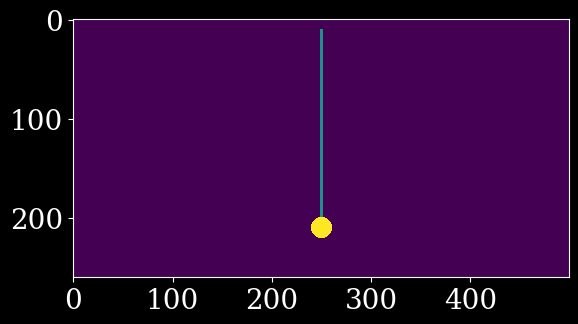

In [16]:
template = genData.create_pendulum_image(0)

plt.figure()    
plt.imshow(template,interpolation='nearest')

In [48]:

import torchvision.transforms as transforms

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type = "Dataset_decoder")
visual_loader= loader.getLoader(a, split=False, type = "Dataset_decoder")

device = "cuda" if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([
    transforms.PILToTensor()
])
transform =  transforms.ToTensor()
template = genData.create_pendulum_image(0)
template = transform(template).to(device)

print(type(template))
print(template.dtype)


ConvAE = modelConv2d.ConvAE(template=template, initw=True)
ConvAE, train_losses, val_losses, accuracy_list  = train.train(ConvAE, train_dataloader, test_dataloader, 'ConvAE', loss_name='ConvAE_decoder_loss')

<class 'torch.Tensor'>
torch.float32
Using device: cpu
x: torch.Size([32, 12, 61, 121])  d3: torch.Size([1, 12, 32, 62])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 122 but got size 32 for tensor number 1 in the list.

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

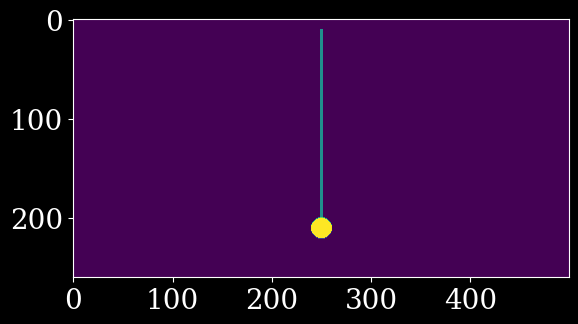

In [14]:
loader.get_template()

In [39]:
x = torch.tensor([1, 2, 3])
print(x, x.shape)
x = x.unsqueeze(0)
print(x, x.shape)
x = x.repeat(4,2)
print(x, x.shape)

tensor([1, 2, 3]) torch.Size([3])
tensor([[1, 2, 3]]) torch.Size([1, 3])
tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]]) torch.Size([4, 6])


# Test

In [7]:
from PIL import Image

from PIL.TiffTags import TAGS
import numpy as np

with Image.open('488pts.tif') as img:

    img_np = np.array(img)
    print(img_np.shape)

(1152, 1152)
